# DATA PROJECT

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# import dst data loader
import pydst
Dst = pydst.Dst(lang='en') 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

We have chosen to look at data on Industrial Robots using licensed data from the Industrial Federation of Robotics. The data is imported as a csv-file, which we will then clean and merge on to data on employment and productivity for Denmark using API's for Statistikbanken. Plots and analysis of the data can work as an insight in to the dynamics and effects of automation in the labor market. 

The Industrial Federation of Robotics provide information on the number of industrial robots within an industry for range of countries. Data is available for 19 industries, of which the level of aggregation varies. As an example, data within the Manufacturing industry is available on a more granular level than within the industry of Service. We use a crosswalk to convert the industry codes from Statistikbanken to the corresponding industry-codes from the IFR-database. This way we can couple the number of robots within an industry with employment to scale the number of robots according to the size of the industry to obtain a relative measure for the exposure to robots within an industry.

In [106]:
# Data for industrial robots on industry, year for Denmark
filename = 'ifr_dk.csv'
df_ifr = pd.read_csv(filename, delimiter=';')

# Drop obs that are not relevant (data not valid before 2004)
drop = [str(year) for year in range(1993,2004)]
df_ifr.drop(drop, axis=1, inplace=True)
df_ifr = df_ifr.iloc[1:20, :]

# Renaming columns
col_dict = {}
for i in range(2004, 2016+1): 
    col_dict[str(i)] = f'year{i}' 
    df_ifr[str(i)] = df_ifr[str(i)].apply(str)
col_dict['DK'] = f'BRANCHE_IFR' 

# Omdøber kolonner
df_ifr.rename(columns=col_dict, inplace=True)

# Transponerer med melt
df_ifr_long = pd.melt(df_ifr, id_vars=['BRANCHE_IFR'], var_name='year', value_name='value')
df_ifr_long['year'] = df_ifr_long['year'].str.replace('year', '').astype(int)


Importing data from Danmarks Statistik:

In [176]:
# Inspicerer indhold
nabb69_vars = Dst.get_variables(table_id='NABB69')
nabb69_vars.id.unique()

# Importing data from statistikbanken through an API
variables = {'SOCIO':['EMPM_DC'],'BRANCHE':['*'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer data
nabb69 = Dst.get_data(table_id = 'NABB69', variables=variables)
nabb69.sort_values(by=['SOCIO', 'TID', 'BRANCHE'], inplace=True)

# Ordner industri-koder: Klar til merge med ifr
# Dictionary for oversættelse af industri-koder
industry = nabb69.BRANCHE
dict_nabb69    = {x[:5]: x[6:] for x in industry}
dict_crosswalk = {'01000':'A-B-Agriculture, forestry, fishing',
                  '02000':'A-B-Agriculture, forestry, fishing',
                  '03000':'A-B-Agriculture, forestry, fishing',
                  '06090':'C-Mining and quarrying',
                  '10120': '10-12-Food and beverages',
                  '13150':'13-15-Textiles',
                  '16000': '16-Wood and furniture',
                  '17000':'17-18-Paper',
                  '18000':'17-18-Paper',
                  '19000':'19-22-Plastic and chemical products',
                  '20000':'19-22-Plastic and chemical products',
                  '21000':'19-22-Plastic and chemical products',
                  '22000':'19-22-Plastic and chemical products',
                  '23000':'23-Glass, ceramics, stone, mineral products (non-auto',
                  '24000':'24-Basic metals',
                  '25000':'25-Metal products (non-automotive)',
                  '28000':'28-Industrial machinery',
                  '26000':'26-27-Electrical/electronics',
                  '27000':'26-27-Electrical/electronics',
                  '29000':'29-Automotive',
                  '30000':'30-Other vehicles',
                  '31320':'91-All other manufacturing branches',
                  '33000':'91-All other manufacturing branches',
                  '35000':'E-Electricity, gas, water supply',
                  '36000':'E-Electricity, gas, water supply',
                  '37390':'E-Electricity, gas, water supply',
                  '41430':'F-Construction',
                  '72002':'P-Education/research/development',
                  '85202':'P-Education/research/development'}

# Opdaterer dictionary så alle andre kategorier får '90'.
dict_crosswalk.update({
    str(key): '90-All other non-manufacturing branches'
    for key in range(0, 100000)
    if str(key) not in dict_crosswalk
})

# Tilføjer ny variabel med talkoder for branche og bruger dictionary til at oversætte industrikoder
nabb69['BRANCHE_K']   = nabb69['BRANCHE'].str[:5]
nabb69['BRANCHE_IFR'] = nabb69['BRANCHE_K'].map(dict_crosswalk)

# Aggregerer på IFR-industrier og tid
nabb69['emp_ifr'] = nabb69.groupby(['BRANCHE_IFR', 'TID'])['INDHOLD'].transform(sum)

nabb69 = nabb69[nabb69['BRANCHE_K'].str.isnumeric()]

# Beholder kun subset: relevante obs og variable
nabb69 = nabb69.loc[:, ['TID', 'BRANCHE_IFR', 'emp_ifr']]
nabb69 = nabb69.drop_duplicates(subset=['BRANCHE_IFR', 'TID'])
nabb69.rename(columns={'TID': 'year'}, inplace=True)


# Analysis

First part: Descriptive statistics

Gør data klar til plot

In [177]:
# Merger datasæt på IFR og year
ifr_nabb69 = pd.merge(df_ifr_long, nabb69, on=['BRANCHE_IFR', 'year'], how='left')
ifr_nabb69.value = ifr_nabb69.value.astype(float)

# Laver dictionary med pænerer værdier på IFR-navne til legends
dict_legend = {
    'A-B-Agriculture, forestry, fishing': 'Agriculture, forestry, fishing',
    'C-Mining and quarrying': 'Mining and quarrying',
    '10-12-Food and beverages': 'Food and beverages',
    '13-15-Textiles': 'Textiles',
    '16-Wood and furniture': 'Wood and furniture',
    '17-18-Paper': 'Paper',
    '19-22-Plastic and chemical products': 'Plastic and chemical products',
    '23-Glass, ceramics, stone, mineral products (non-auto': 'Glass, ceramics, stone, mineral products',
    '24-Basic metals': 'Basic metals',
    '25-Metal products (non-automotive)': 'Metal products (non-automotive)',
    '26-27-Electrical/electronics': 'Electrical/electronics',
    '28-Industrial machinery': 'Industrial machinery',
    '29-Automotive': 'Automotive',
    '30-Other vehicles': 'Other vehicles',
    '91-All other manufacturing branches': 'All other manufacturing branches',
    'E-Electricity, gas, water supply': 'Electricity, gas, water supply',
    'F-Construction': 'Construction',
    'P-Education/research/development': 'Education/research/development',
    '90-All other non-manufacturing branches': 'All other non-manufacturing branches'
}

ifr_nabb69['ifr_legend'] = ifr_nabb69['BRANCHE_IFR'].map(dict_legend)

# Udregner robost pr. ths. worker (relativt mål for robot-intensiteten i en industri)
ifr_nabb69['rob_pr_ths'] = ifr_nabb69.value/ifr_nabb69.emp_ifr
#ifr_nabb69 = ifr_nabb69.dropna()

# Udregner mean pr. år på tværs af industrier
rob_pr_ths_mean      = ifr_nabb69.groupby(['year'])['rob_pr_ths'].mean()
ifr_nabb69           = pd.merge(ifr_nabb69, rob_pr_ths_mean, on=['year'], how='left')

# Renamer kolonner
ifr_nabb69.rename(columns={'rob_pr_ths_x': 'rob_pr_ths',
                           'rob_pr_ths_y': 'rob_pr_ths_y_mean'}, inplace=True)

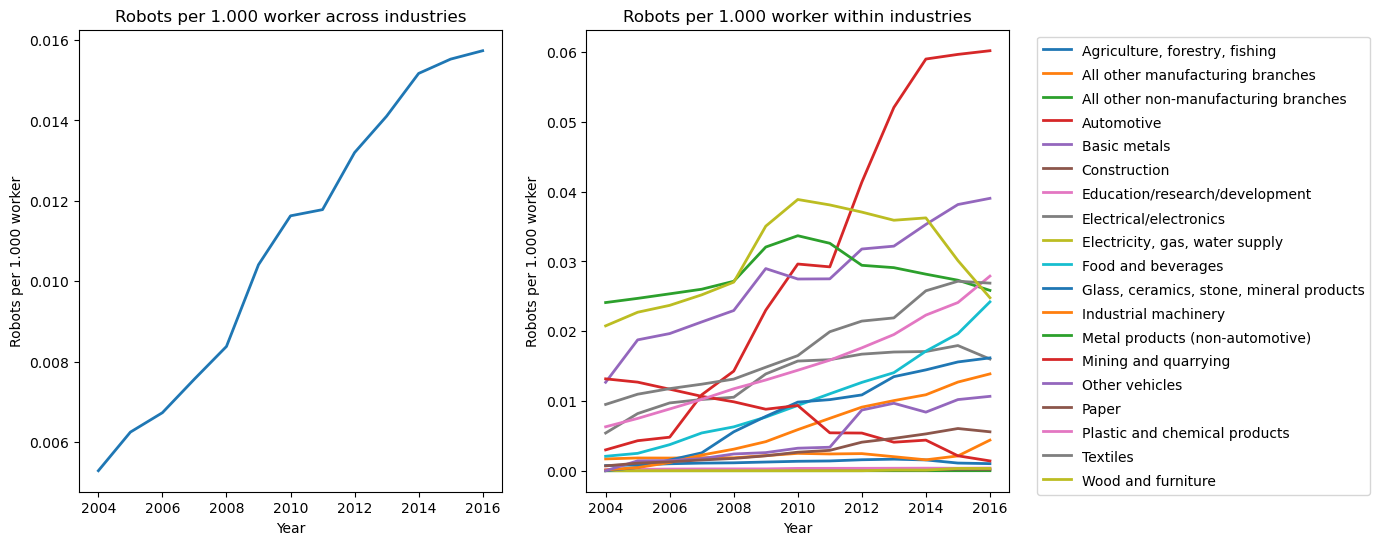

In [178]:
# Plot
def plot_rob_pr_ths_by_indu():
    plot = plt.figure(figsize=(12,6))

    # a. create line plot for aggregate development in robots across industries
    ax = plot.add_subplot(1,2,1)

    ax.plot(ifr_nabb69.year, ifr_nabb69.rob_pr_ths_y_mean, label=None, marker=None, linestyle='-', linewidth=2)
    #x_pos = ifr_nabb69.year.iloc[-1] + 0.2
    #y_pos = ifr_nabb69.rob_pr_ths_y_mean.iloc[-1]
    
    ax.set_title(f'Robots per 1.000 worker across industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')

    # b. plot for each industry
    ax = plot.add_subplot(1,2,2)

    for industry, data in ifr_nabb69.groupby('ifr_legend'):
        #ax.plot(data.year, data.rob_pr_ths, label=None, marker=None, linestyle='-', linewidth=2)
        ax.plot(data.year, data.rob_pr_ths, label=industry, marker=None, linestyle='-', linewidth=2)
        #x_pos = data.year.iloc[-1] + 0.2
        #y_pos = data.rob_pr_ths.iloc[-1]
        #ax.annotate(industry, xy=(x_pos, y_pos), ha='left', va='center')

    ax.set_title(f'Robots per 1.000 worker within industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), handleheight=1.5)

plot_rob_pr_ths_by_indu()  

In [179]:
# Importing NP25: Enhed for alle værdier er årlig vækstrate i pct.
np25_vars = Dst.get_variables(table_id='NP25')
np25_vars.id.unique()

# Importing data from statistikbanken through an API
variables = {'BRANCHE':['*'],'TYPE':['LP', 'IT', 'AK', 'LQ', 'TF'],'PRISENHED':['VPR_V'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer udvalgt subset af data
np25 = Dst.get_data(table_id = 'NP25', variables=variables)
np25.sort_values(by=['TYPE', 'TID', 'BRANCHE'], inplace=True)

# Create binary mask with trues where digit values in the 'BRANCHE_K' column
np25.loc[:, 'BRANCHE_K'] = np25['BRANCHE'].str[:5]
mask = np25['BRANCHE_K'].str.isdigit()

# Select only the rows that meet the condition
np25 = np25.loc[mask, :]

# Tilføjer ny variabel med talkoder for branche og bruger dictionary til at oversætte industrikoder
np25['BRANCHE_IFR'] = np25['BRANCHE_K'].map(dict_crosswalk)


# Transponerer med melt
# pivot dataframe
np25 = np25.pivot(index=['BRANCHE', 'PRISENHED', 'TID', 'BRANCHE_K', 'BRANCHE_IFR'], columns='TYPE', values='INDHOLD').reset_index()

# rename columns
np25.columns.name = None
np25 = np25.rename(columns={
    '01000 Agriculture and horticulture': 'BRANCHE',
    'Annual growth rate in per cent': 'PRISENHED',
    'A-B-Agriculture, forestry, fishing': 'BRANCHE_IFR'
})

# Convert to float
prod_var = ['Educational level', 'It-Capital deepening', 'Labour productivity', 'Non IT-capital deepening', 'Total factor productivity']
np25[prod_var] = np25[prod_var].applymap(lambda x: np.nan if x == '..' else float(x))

# Aggregerer på IFR-industrier og tid
np25 = np25.groupby(['BRANCHE_IFR', 'TID']).agg({
    'Educational level': 'sum',
    'It-Capital deepening': 'sum',
    'Labour productivity': 'sum',
    'Non IT-capital deepening': 'sum',
    'Total factor productivity': 'sum'
}).reset_index()

# Renamer kolonne
np25.rename(columns={'TID': 'year'}, inplace=True)

# Stadig 19 industrier
print(np25['BRANCHE_IFR'].nunique())

# Sort the dataframe by the 'variable_name' column in ascending order
np25.sort_values(by=['year', 'BRANCHE_IFR'], inplace=True)
np25.reset_index(drop=True, inplace=True)

19


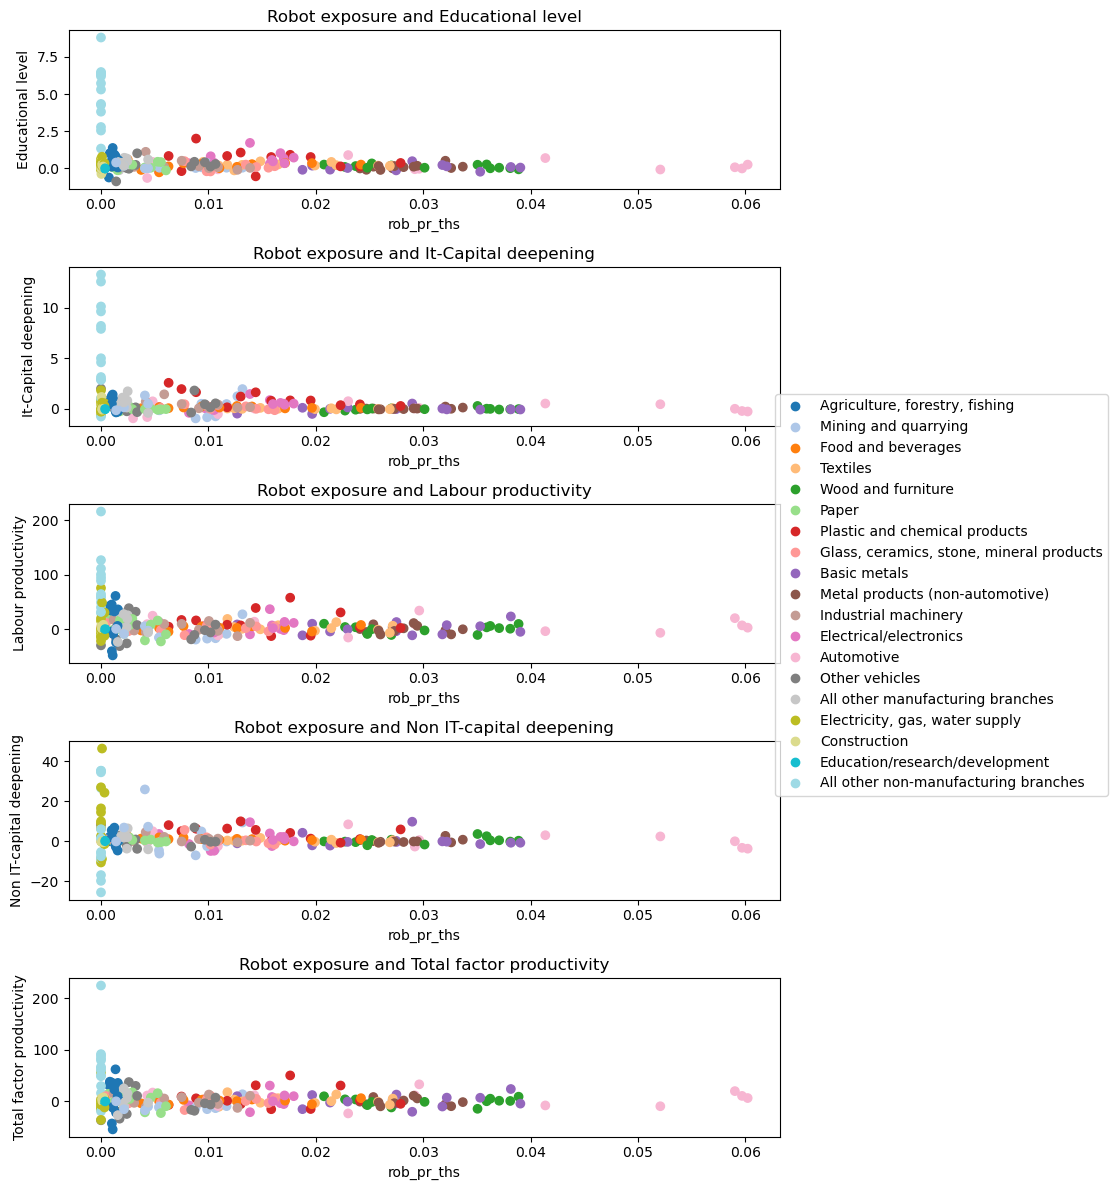

In [180]:
# Merger NP25 på eksisterende data på IFR-industrier og tid
ifr_nabb69_np25 = pd.merge(ifr_nabb69, np25, on=['BRANCHE_IFR', 'year'], how='left')

# Plot
def plot_scatter_by_prod_measure():
    # Laver scatterplot for de 5 productivitetsmål:
    # Colormap
    cmap = plt.cm.get_cmap('tab20', 19)
    industry_labels = ifr_nabb69_np25['ifr_legend'].unique()
    industry_colors = [cmap(i) for i in range(len(industry_labels))]
    color_dict = dict(zip(industry_labels, industry_colors))

    # Assign a color to each data point based on its industry
    colors = [color_dict[label] for label in ifr_nabb69_np25['ifr_legend']]

    fig, axes = plt.subplots(nrows=5, figsize=(8, 12))

    # Loop through each subplot and plot the corresponding y-variable
    for i, ax in enumerate(axes):
        ax.scatter(ifr_nabb69_np25.rob_pr_ths, ifr_nabb69_np25[prod_var[i]], c=colors)
        ax.set_xlabel('rob_pr_ths')
        ax.set_ylabel(prod_var[i])
        ax.set_title(f'Robot exposure and {prod_var[i]}')


    # Create a legend object
    handles = [plt.plot([], [], marker="o", ls="", color=color_dict[label], label=label)[0] for label in industry_labels]
    plt.subplots_adjust(right=88) # adjust the right margin to make room for the legend
    fig.legend(handles, industry_labels, loc="center right", bbox_to_anchor=(1.4, 0.5))

    # Adjust the layout and spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_scatter_by_prod_measure()  

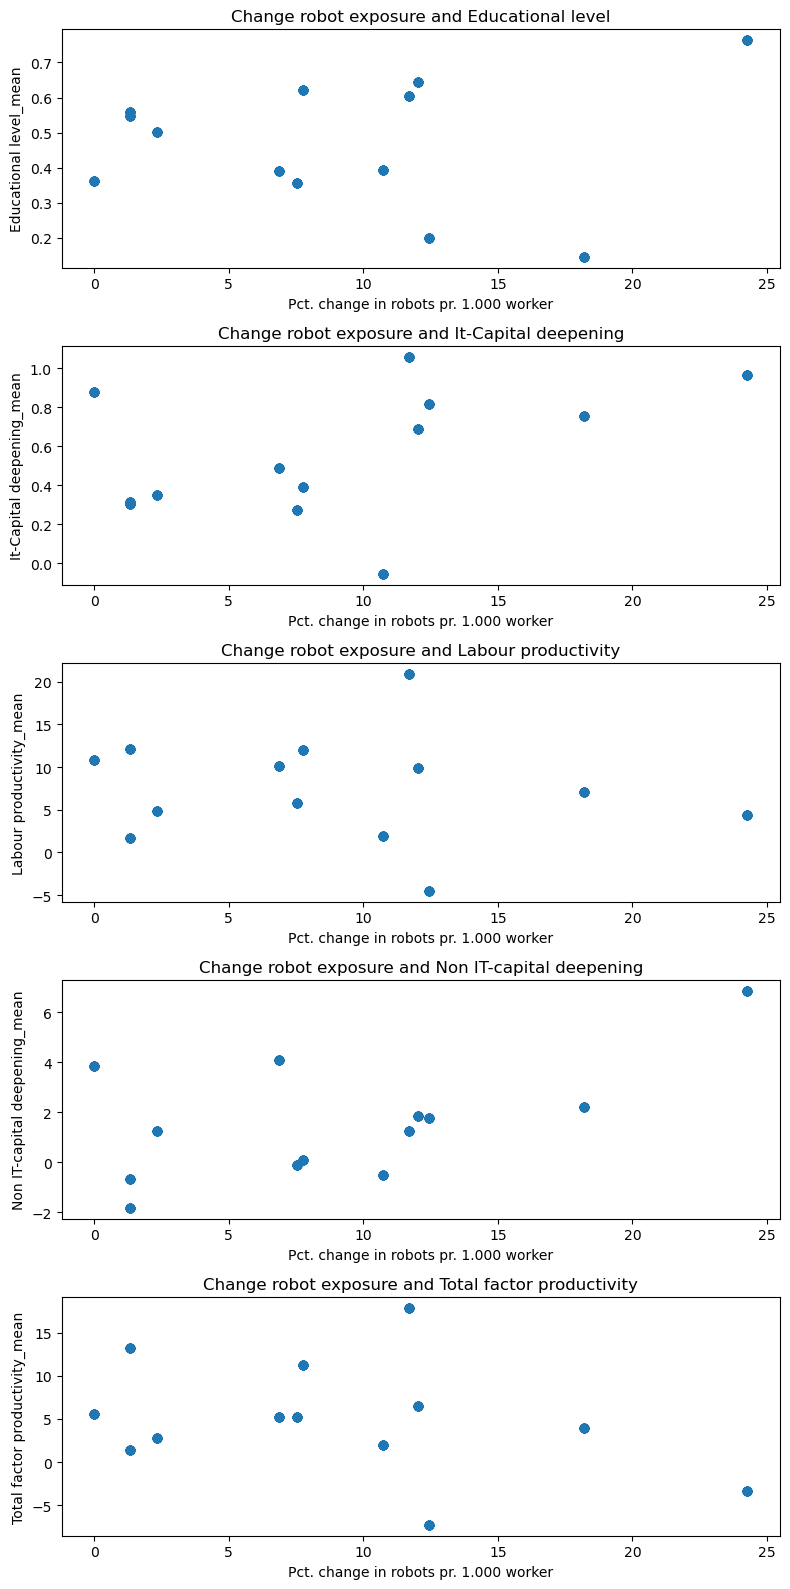

In [181]:
# Udregner mean på år for hvert produktivitetsmål (industrier kollapses)

# Sort the dataframe by the 'variable_name' column in ascending order
np25.sort_values(by=['year', 'BRANCHE_IFR'], inplace=True)
np25.reset_index(drop=True, inplace=True)

# Udregner mean pr. år på tværs af industrier: prod_var er en liste over relevante produktivitetsvariable
prod_var_mean = []
for var in prod_var:
    var_mean = ifr_nabb69_np25.groupby(['year'])[var].mean()
    # Rename column to assign _mean
    ifr_nabb69_np25[var + '_mean'] = ifr_nabb69_np25['year'].map(var_mean)
    # Appender gennemsnitsværdier til ny liste
    prod_var_mean.append(var + '_mean')

# Apply the pct_change method to each group for two groupings: within year only as well as within year, industry
ifr_nabb69_np25['D_rob_pr_ths_y_mean'] = ifr_nabb69_np25['rob_pr_ths_y_mean'].pct_change() * 100

# Fill NaN values with first observation within each group
ifr_nabb69_np25['D_rob_pr_ths_y_mean'] = ifr_nabb69_np25.groupby('year')['D_rob_pr_ths_y_mean'].transform('first')

def plot_scatter_mean_by_prod_measure():
    # Plotting
    fig, axes = plt.subplots(nrows=5, figsize=(8, 16))

    # Loop through each subplot and plot the corresponding y-variable
    for i, ax in enumerate(axes):
        ax.scatter(ifr_nabb69_np25.D_rob_pr_ths_y_mean, ifr_nabb69_np25[prod_var_mean[i]].values)
        ax.set_xlabel('Pct. change in robots pr. 1.000 worker')
        ax.set_ylabel(prod_var_mean[i])
        ax.set_title(f'Change robot exposure and {prod_var[i]}')

    # Adjust the layout and spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
plot_scatter_mean_by_prod_measure()



As we have relatively few datapoints it is difficult to detect any clear correlation between each measure of productivity and the yearly change in robots pr. 1.000 worker. 

To investigate the relationsship between robot exposure within an industry, we will use regression analysis using the empirical specification below: 

$$\Delta prod_{i,t}=\alpha + \beta \Delta robexp_{i,t} + \epsilon$$

where $i$ is industry and $t$ is year. $\Delta prod_{i,t}$ indicates the percentage change of one of five productivity measures and $\Delta robexp{i,t}$ is the percentage change in exposure to industrial robots within a given year and industry. For each regression we should have access to $i \cdot t = 19 \cdot 13 = 247$ unique observations. However, as a result of missing values we are left with $208$ observations for each OLS-estimation. 

The dependent variables of interest are the following five productivity measures:

1. Educational level
2. IT-Capital deepening (software use in production)
3. Labour productivity 
4. Non IT-capital deepening (general investments)
5. Total Factor Productivity (TFP)


In [183]:
# Getting data ready for regression analysis

# Sorting data before calculating percentage change 
ifr_nabb69_np25.sort_values(by=['BRANCHE_IFR', 'year'], inplace=True)
ifr_nabb69_np25.reset_index(drop=True, inplace=True)

# Group by industry and apply pct_change to 'rob_pr_ths'
grouped = ifr_nabb69_np25.groupby(['BRANCHE_IFR'])
ifr_nabb69_np25['D_rob_pr_ths'] = grouped['rob_pr_ths'].pct_change() * 100

# Fill NA's with calculated values
ifr_nabb69_np25['D_rob_pr_ths'] = ifr_nabb69_np25['D_rob_pr_ths'].fillna(grouped['rob_pr_ths'].transform('first'))

In [184]:
# Regression analysis using OLS

# Drop invalid observations where D_rob_pr_ths is nan or inf
ifr_nabb69_np25 = ifr_nabb69_np25[~(np.isinf(ifr_nabb69_np25['D_rob_pr_ths']) | np.isnan(ifr_nabb69_np25['D_rob_pr_ths']))]

# Load data
results_list = []  # List to store regression results
for var in prod_var:
    y = ifr_nabb69_np25[var]
    X = sm.add_constant(ifr_nabb69_np25['D_rob_pr_ths'])  # Add constant for intercept term
    model = sm.OLS(y, X)    # Define model
    results = model.fit()   # Fit model
    results_list.append(results)  # Append regression results to list

# Print summary for each regression model to a file
with open("regression_results.txt", "w") as f:
    for i, var in enumerate(prod_var):
        f.write("Regression Results for {}: \n{}\n".format(var, results_list[i].summary()))
        
    # Print summary of all regression models to file
    f.write("Summary of All Regression Models:\n")
    summary = summary_col(results_list, model_names=prod_var, float_format="%.2f")
    f.write(summary.as_text())
    
# Print contents of file to console
with open("regression_results.txt", "r") as f:
    print(f.read())

# Output is too large to display in the .py-file but can be viewed in external text-editor. 

Regression Results for Educational level: 
                            OLS Regression Results                            
Dep. Variable:      Educational level   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1196
Date:                Sat, 15 Apr 2023   Prob (F-statistic):              0.730
Time:                        20:48:48   Log-Likelihood:                -375.67
No. Observations:                 243   AIC:                             755.3
Df Residuals:                     241   BIC:                             762.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

# Conclusion

ADD CONCISE CONLUSION.